In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [20]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore
from codes.metrics import ContourEval

In [3]:
from torchmetrics import Recall

In [4]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
ACT = None
AUX_PARAM = None

### Optimizer Settings

In [9]:
OPTIM_NAME = "sgd"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = 0
    psnr_ = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)
        
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)

        ssim_ += _ssim.item()
        psnr_ += _psnr.item()

    return  ssim_/(index+1), psnr_/(index+1)

In [12]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim = 0
    psnr = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)

        x = x.squeeze().cpu().numpy()
        y = y.squeeze().cpu().numpy()
        y_pr = y_pr.squeeze().cpu().numpy() * 255
        y_pr = y_pr.astype(np.uint8)

        visualize(
            cbct = x,
            ct_y = y,
            ct_pred = y_pr,
        )

# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug
from codes.utils import min_max_normalize, find_mask
from segmentation_models_pytorch.utils.metrics import IoU

In [14]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
# testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [ ]:
len(trainset), len(testset)

In [ ]:
i = 0
for data in trainset:
    if i > 20:
        break
    x, y, air_x, bone = data
    visualize(
        x = x.squeeze(),
        y = y.squeeze(),
        air_x = air_x.squeeze(),
        bone = bone.squeeze()
    )
    ++i

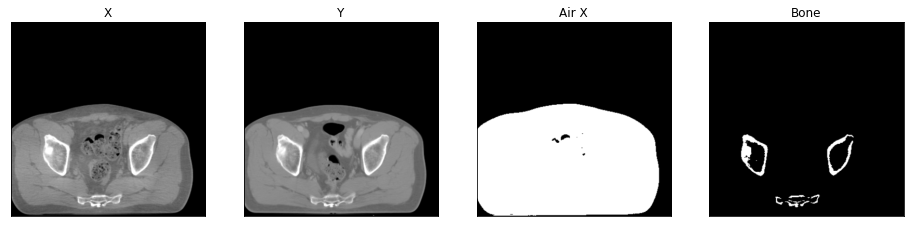

In [24]:
x, y, air_x, bone = trainset[20]

x = x.squeeze()
y = y.squeeze()
air_x = air_x.squeeze()
bone = bone.squeeze()

visualize(
    x = x,
    y = y,
    air_x = air_x,
    bone = bone
)

In [25]:
ContourEval()(x, y)

tensor(0.3473)

In [26]:
ContourEval()(x, x)

tensor(1.)

0.29880478978157043


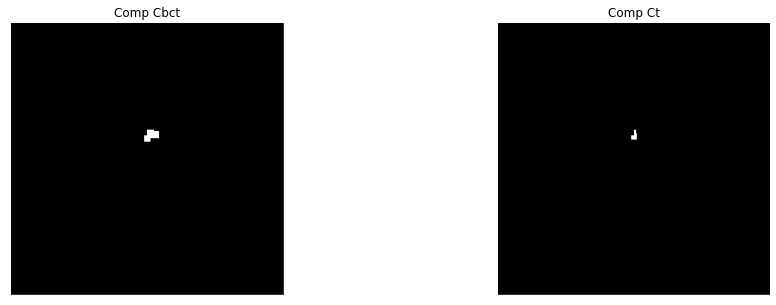

0.8722094893455505


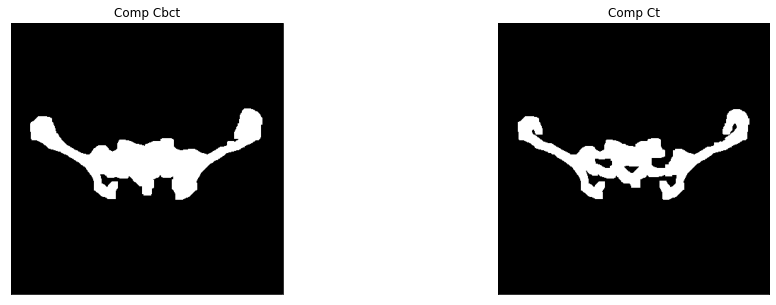

4.405286413433629e-10


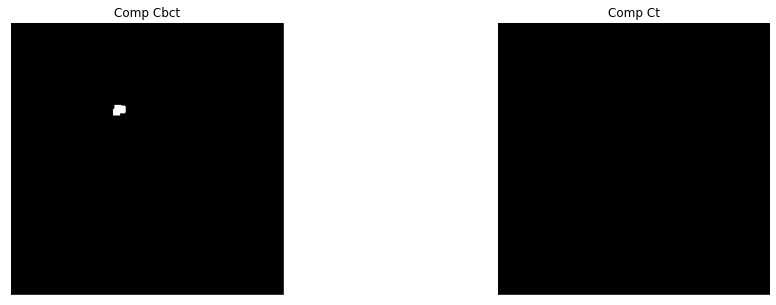

3.067484599661441e-10


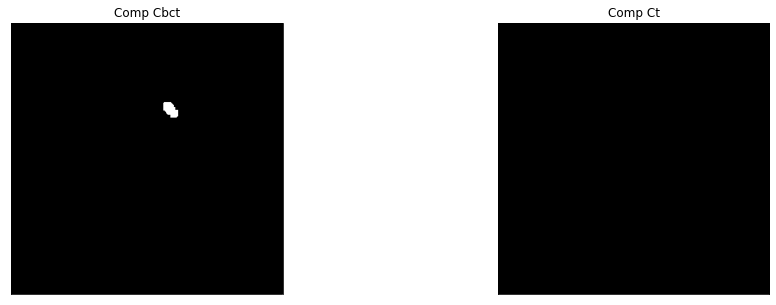

8.474576596029237e-10


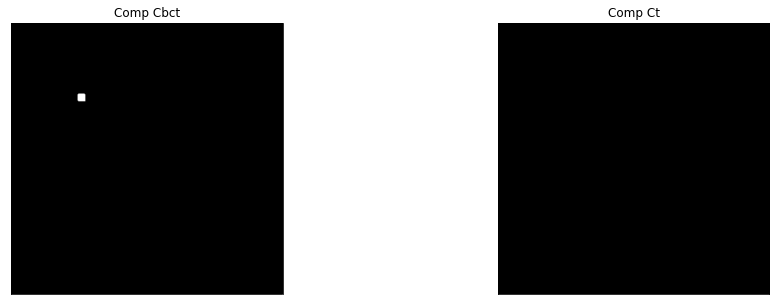

7.352941033822447e-10


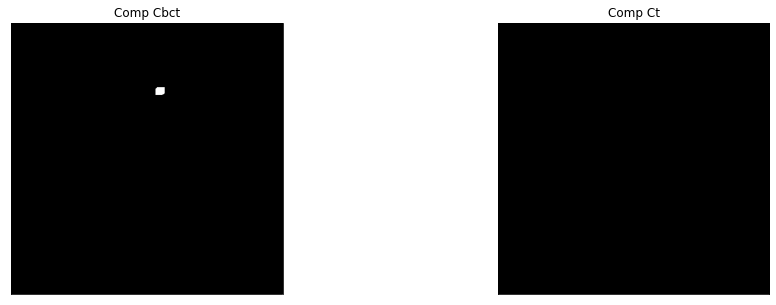

1.8050541616965177e-10


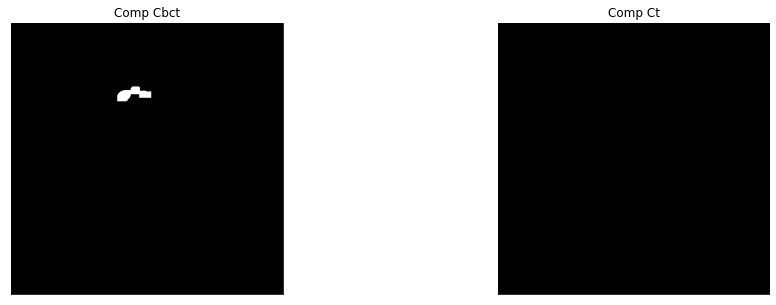

5.917160095236795e-10


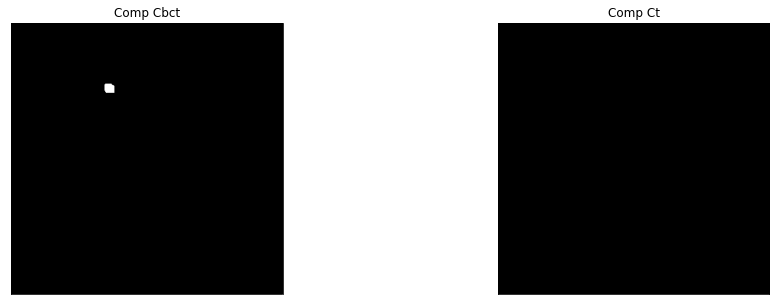

0.0 1.0


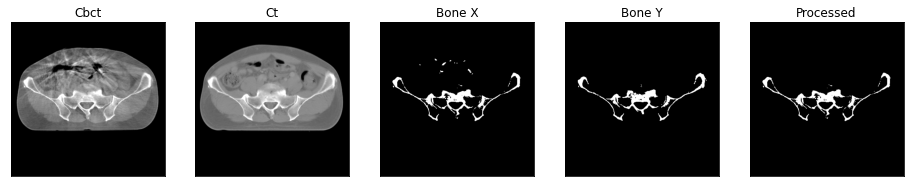

In [42]:
# x, y, _, _, bone_x, bone_y = data
x = x.squeeze()
y = y.squeeze()
bone_x = bone_x.squeeze()
bone_y = bone_y.squeeze()

bone_x = (bone_x * 255).astype(np.uint8)
bone_y = (bone_y * 255).astype(np.uint8)

kernel = np.ones((9, 9), np.uint8)
dilate_x = cv2.dilate(bone_x, kernel, iterations = 1)
dilate_y = cv2.dilate(bone_y, kernel, iterations = 1)

cnts, hier = cv2.findContours(dilate_x.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
height, width = dilate_y.shape

comps = []
for cnt in cnts:
    empty = np.zeros((height, width, 3), dtype=np.uint8)
    cv2.drawContours(empty, [cnt], 0, (255, 255, 255), -1)
    empty = empty.astype(np.float32) / 255
    empty = empty[:, :, 0]
    empty_y = dilate_y * empty
    
    iou = IoU()(torch.from_numpy(empty_y), torch.from_numpy(empty))
    print(iou.item())
    visualize(
        comp_cbct = empty,
        comp_ct = empty_y
    )
    if iou > 0.1:
        comps += [empty]
    else:
        pass

comps = np.stack(comps, axis=-1)
comps = comps.max(-1)
processed = bone_x * comps


visualize(
    cbct = x,
    ct = y,
    bone_x = bone_x,
    bone_y = bone_y,
    processed = processed
)

In [70]:
sobel_cbct = cv2.Sobel(cbct, cv2.CV_64F, 1, 1)
sobel_ct = cv2.Sobel(ct, cv2.CV_64F, 1, 1)

In [71]:
_cbct = np.where(sobel_cbct < 0, 0, sobel_cbct)
_ct = np.where(sobel_ct < 0, 0, sobel_ct)

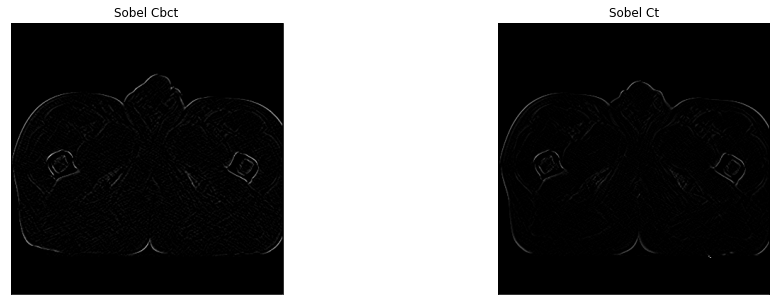

In [72]:
visualize(
    sobel_cbct = _cbct,
    sobel_ct = _ct
)

In [24]:
sobel_cbct.min(), sobel_cbct.max()

(-0.5979999899864197, 0.6040000100620091)

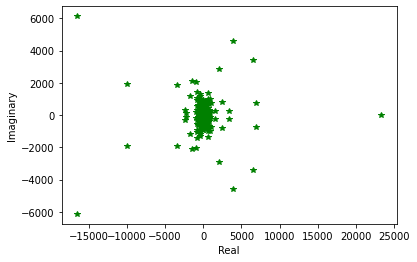

In [25]:
complex_arr = np.fft.fft2(cbct)
x = complex_arr.real
y = complex_arr.imag
plt.plot(x, y, 'g*')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

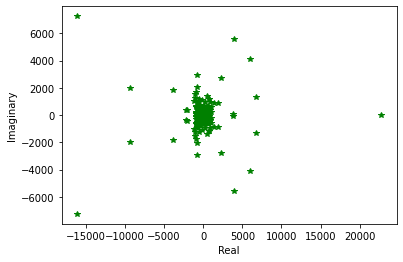

In [26]:
complex_arr = np.fft.fft2(ct)
x = complex_arr.real
y = complex_arr.imag
plt.plot(x, y, 'g*')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [27]:
x.shape, y.shape

((384, 384), (384, 384))

In [53]:
bone = (bone_x * 255).astype(np.uint8)
cnts, hier = cv2.findContours(bone.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

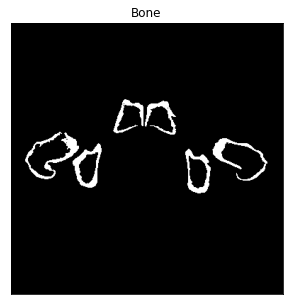

In [54]:
visualize(bone=bone_x)

In [55]:
len(cnts)

6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


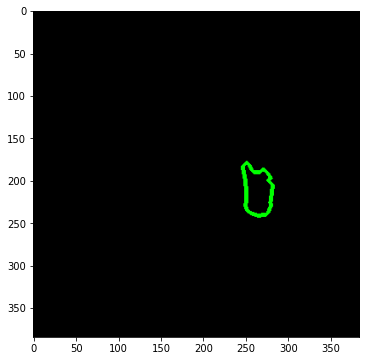

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


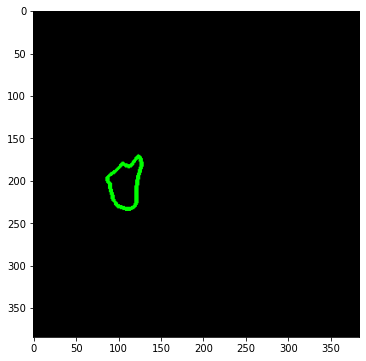

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


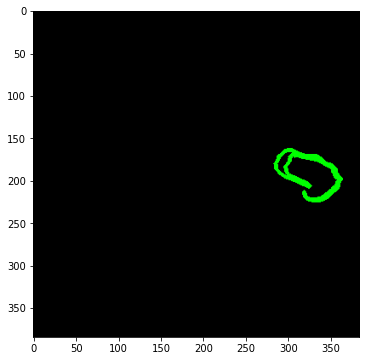

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


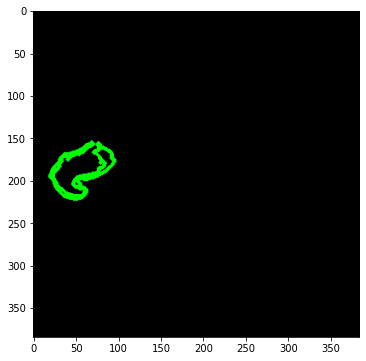

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


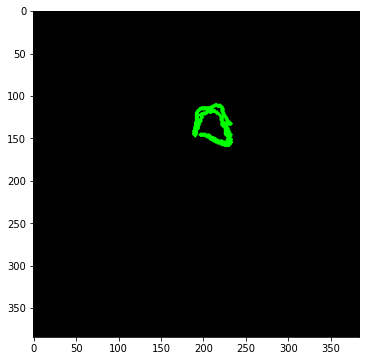

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


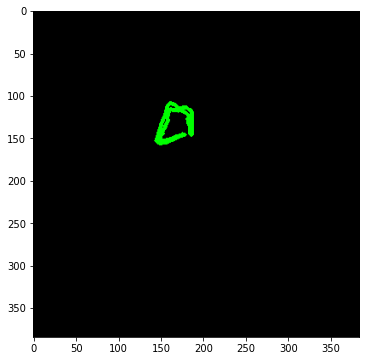

In [60]:
import copy

for c in cnts:
    img = np.zeros((bone.shape[0], bone.shape[1], 3))
    cv2.drawContours(img, [c], 0, (0, 255, 0), 3)
    plt.figure(0, figsize=(6,6))
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


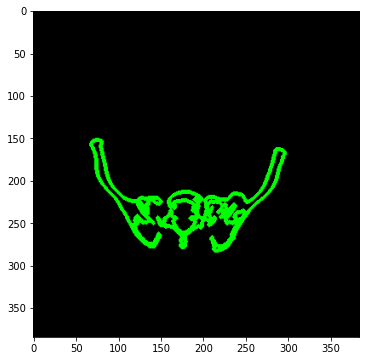

In [32]:
img = np.zeros((bone.shape[0], bone.shape[1], 3))
cv2.drawContours(img, cnts, -1, (0, 255, 0), 3)
plt.figure(0, figsize=(6,6))
plt.imshow(img)
plt.show()

In [ ]:
from skimage import io, morphology
for data in trainset:
    x, y, air_x, air_y, bone_x, bone_y = data
    
    bone_x = (bone_x.squeeze() * 255).astype(np.uint8)
    kernel=(5, 5)
    kernel = np.ones(kernel, np.uint8)
    b_dilate = cv2.dilate(bone_x, kernel, iterations = 1)
    
#     cnts, hier = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     cnts, hier = cv2.findContours(bone_x.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     img = np.zeros((bone_x.shape[0], bone_x.shape[1], 3))
#     cv2.drawContours(img, cnts, -1, (255, 255, 255), -1)
#     kernel = np.ones(kernel, np.uint8)
    
#     img2 = np.zeros((img.shape[0], img.shape[1], 3))
#     cv2.drawContours(img2, cnts, -1, (255, 255, 255), -1)
# #     c = max(cnts, key = cv2.contourArea)
#     c = c.squeeze()
    
#     xmax, ymax = c.max(axis=0)
#     xmin, ymin = c.min(axis=0)
    
    visualize(
        cbct = x.squeeze(),
        ct = y.squeeze(),
        bone_x = bone_x,
        b_dilate = b_dilate
    )

In [ ]:
x_max = 438
x_min = 82
y_max = 349
y_min = 96